### Data Preparation and Exploration

In [ ]:
pip install ucimlrepo

In [ ]:
!pip install shap

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.utils import class_weight
import gc
import matplotlib.pyplot as plt
import shap

In [ ]:
# Fetch dataset
dataset = fetch_ucirepo(id=601)
X, y = dataset.data.features, dataset.data.targets

# Focus on 'Machine failure' and drop other failure modes
y = y[['Machine failure']]

# Check dataset metadata and variables
print(dataset.metadata)
print(dataset.variables)


{'uci_id': 601, 'name': 'AI4I 2020 Predictive Maintenance Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/601/data.csv', 'abstract': 'The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression', 'Causal-Discovery'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 10000, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'index_col': ['UID', 'Product ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5HS5C', 'creators': [], 'intro_paper': {'ID': 386, 'type': 'NATIVE', 'title': 'Explainable Artificial Intelligen

In [ ]:
# Initial data inspection
print("Features (X):\n", X.head())
print("Target (y):\n", y.head())
X.info()
y.info()
print("\nMissing Values:\n", X.isnull().sum())

Features (X):
   Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool wear  
0          0  
1          3  
2          5  
3          7  
4          9  
Target (y):
    Machine failure
0                0
1                0
2                0
3                0
4                0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process tem

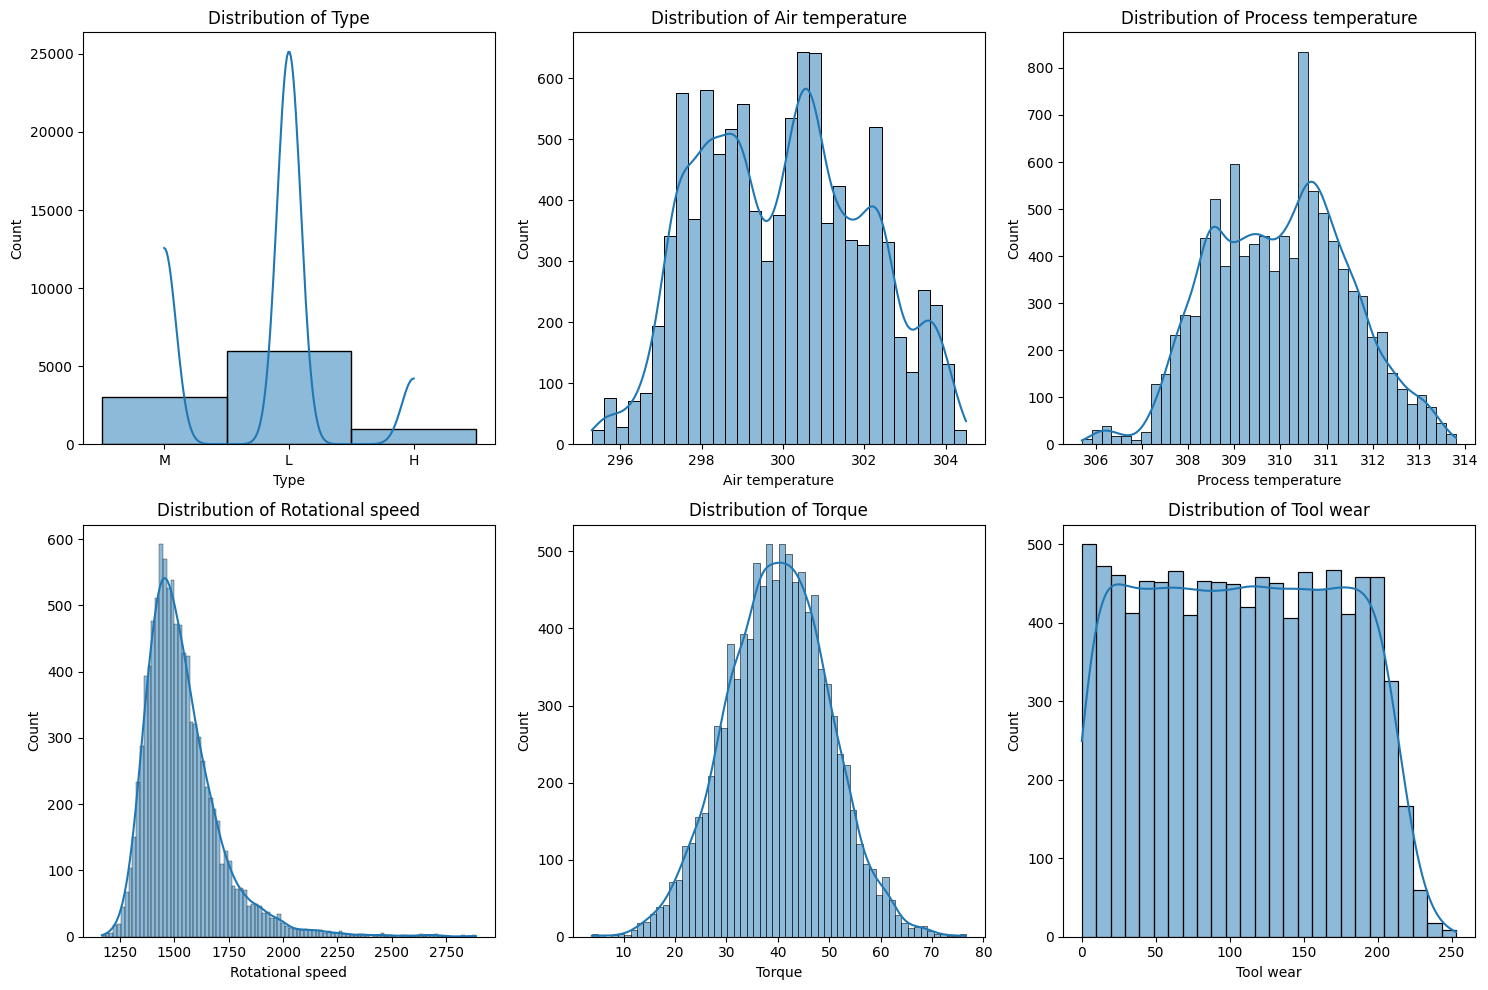

In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [ ]:
# Drop unnecessary columns only if they exist
columns_to_drop = ["UID", "Product ID"]
X = X.drop(columns=[col for col in columns_to_drop if col in X.columns], errors='ignore')

In [ ]:
# Inspect columns in X
print("Columns in X before dropping:", X.columns)

# Drop unnecessary columns only if they exist
columns_to_drop = ["UID", "Product ID"]
X = X.drop(columns=[col for col in columns_to_drop if col in X.columns], errors='ignore')

print("Columns in X after dropping:", X.columns)

Columns in X before dropping: Index(['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear'],
      dtype='object')
Columns in X after dropping: Index(['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear'],
      dtype='object')


In [ ]:
# One-hot encoding for categorical data
X = pd.get_dummies(X, columns=["Type"], drop_first=True)

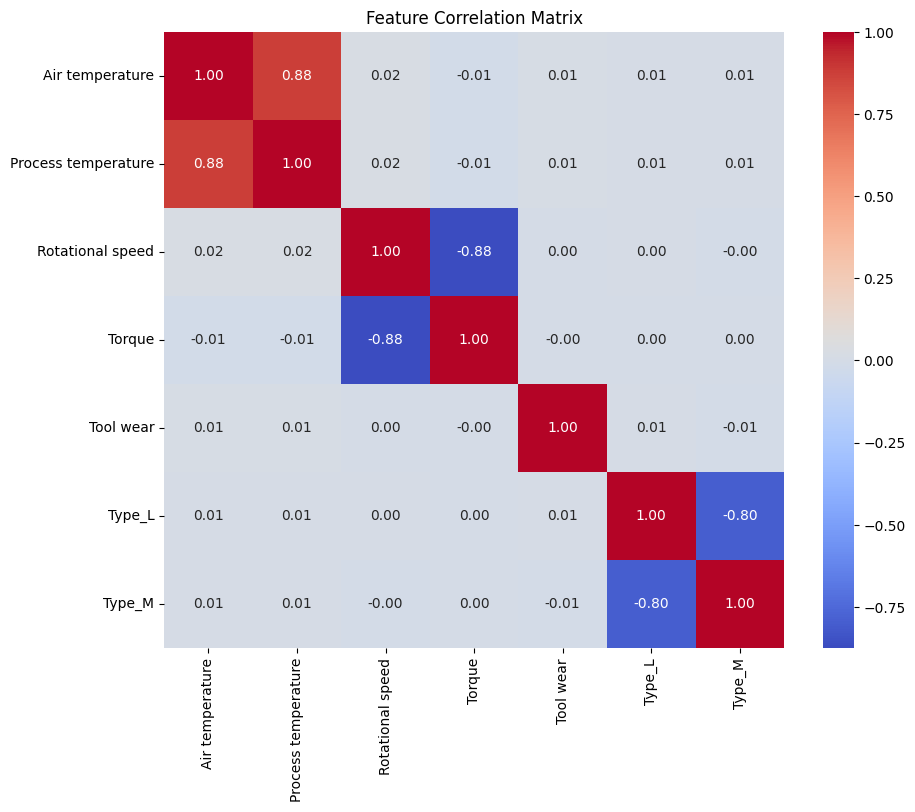

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert targets to numpy arrays for LSTM compatibility
y_train = y_train.values
y_test = y_test.values

### LSTM Implementation

In [ ]:
# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 61
output_dim = 1
learning_rate = 0.4
epochs = 30
batch_size = 128


# Initialize weights and biases
weights = {
    'Wf': np.random.randn(hidden_dim, input_dim) * np.sqrt(2 / (hidden_dim + input_dim)),
    'Wi': np.random.randn(hidden_dim, input_dim) * np.sqrt(2 / (hidden_dim + input_dim)),
    'Wo': np.random.randn(hidden_dim, input_dim) * np.sqrt(2 / (hidden_dim + input_dim)),
    'Wc': np.random.randn(hidden_dim, input_dim) * np.sqrt(2 / (hidden_dim + input_dim)),
    'Uf': np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2 / (hidden_dim + hidden_dim)),
    'Ui': np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2 / (hidden_dim + hidden_dim)),
    'Uo': np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2 / (hidden_dim + hidden_dim)),
    'Uc': np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2 / (hidden_dim + hidden_dim)),
    'V': np.random.randn(output_dim, hidden_dim) * np.sqrt(2 / (hidden_dim + output_dim)),
}
biases = {
    'bf': np.zeros((hidden_dim, 1)),
    'bi': np.zeros((hidden_dim, 1)),
    'bo': np.zeros((hidden_dim, 1)),
    'bc': np.zeros((hidden_dim, 1))
}

In [ ]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Compute gradient of sigmoid
#def sigmoid_derivative(x):
#    return sigmoid(x) * (1 - sigmoid(x))

# Compute gradient of tanh
#def tanh_derivative(x):
#    return 1 - np.tanh(x)**2

In [ ]:
# LSTM cell forward pass
def lstm_cell_forward(xt, h_prev, c_prev, weights, biases):
    ft = sigmoid(np.dot(weights['Wf'], xt) + np.dot(weights['Uf'], h_prev) + biases['bf'])
    it = sigmoid(np.dot(weights['Wi'], xt) + np.dot(weights['Ui'], h_prev) + biases['bi'])
    c_hat = tanh(np.dot(weights['Wc'], xt) + np.dot(weights['Uc'], h_prev) + biases['bc'])
    c_next = ft * c_prev + it * c_hat
    ot = sigmoid(np.dot(weights['Wo'], xt) + np.dot(weights['Uo'], h_prev) + biases['bo'])
    h_next = ot * tanh(c_next)
    y_pred = sigmoid(np.dot(weights['V'], h_next))  # Here I used sigmoid for binary output
    return h_next, c_next, y_pred

In [ ]:
# Forward pass for a sequence
def lstm_forward(X_sequence, h_prev, c_prev, weights, biases):
    h_states, y_preds = [], []
    for xt in X_sequence:
        h_prev, c_prev, y_pred = lstm_cell_forward(xt.reshape(-1, 1), h_prev, c_prev, weights, biases)
        h_states.append(h_prev)
        y_preds.append(y_pred)
    return h_states, y_preds

In [ ]:
# Binary cross-entropy loss
def compute_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [ ]:
# Training phase with gradient descent
epoch_train_losses = []

for epoch in range(epochs):
    epoch_train_loss = 0

    # Training Loop
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train.iloc[i:i + batch_size].values
        y_batch = y_train[i:i + batch_size]

        h_prev_train = np.zeros((hidden_dim, 1))
        c_prev_train = np.zeros((hidden_dim, 1))

        # Initialize gradients
        grad_weights = {key: np.zeros_like(val) for key, val in weights.items()}
        grad_biases = {key: np.zeros_like(val) for key, val in biases.items()}

        # Batch processing
        for j in range(len(X_batch)):
            X_sequence = X_batch[j].reshape(-1, X_batch.shape[1])
            y_true = y_batch[j].reshape(-1, 1)

            # Forward pass
            h_states, y_preds = lstm_forward(X_sequence, h_prev_train, c_prev_train, weights, biases)
            y_pred = y_preds[-1]

            # Compute loss
            loss = compute_loss(y_true, y_pred)
            epoch_train_loss += loss

            # Backpropagation through time
            d_loss = y_pred - y_true  # Derivative of BCE loss
            for t in reversed(range(len(X_sequence))):
                # Gradients for output weights
                grad_weights['V'] += np.dot(d_loss, h_states[t].T)

                # Gradients for LSTM weights (simplified for illustration)
                grad_biases['bo'] += d_loss  # Example for output bias gradient

            # Normalize gradients for batch
            for key in grad_weights:
                grad_weights[key] /= len(X_batch)
            for key in grad_biases:
                grad_biases[key] /= len(X_batch)

        # Update weights and biases using gradient descent
        for key in weights:
            weights[key] -= learning_rate * grad_weights[key]
        for key in biases:
            biases[key] -= learning_rate * grad_biases[key]

    # Average training and validation loss
    epoch_train_loss /= len(X_train)
    epoch_train_losses.append(epoch_train_loss)


    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}")

Epoch 1/30, Train Loss: 0.7034
Epoch 2/30, Train Loss: 0.7022
Epoch 3/30, Train Loss: 0.7011
Epoch 4/30, Train Loss: 0.7001
Epoch 5/30, Train Loss: 0.6992
Epoch 6/30, Train Loss: 0.6984
Epoch 7/30, Train Loss: 0.6976
Epoch 8/30, Train Loss: 0.6970
Epoch 9/30, Train Loss: 0.6964
Epoch 10/30, Train Loss: 0.6959
Epoch 11/30, Train Loss: 0.6954
Epoch 12/30, Train Loss: 0.6950
Epoch 13/30, Train Loss: 0.6946
Epoch 14/30, Train Loss: 0.6943
Epoch 15/30, Train Loss: 0.6941
Epoch 16/30, Train Loss: 0.6938
Epoch 17/30, Train Loss: 0.6936
Epoch 18/30, Train Loss: 0.6935
Epoch 19/30, Train Loss: 0.6933
Epoch 20/30, Train Loss: 0.6932
Epoch 21/30, Train Loss: 0.6931
Epoch 22/30, Train Loss: 0.6931
Epoch 23/30, Train Loss: 0.6930
Epoch 24/30, Train Loss: 0.6930
Epoch 25/30, Train Loss: 0.6929
Epoch 26/30, Train Loss: 0.6929
Epoch 27/30, Train Loss: 0.6929
Epoch 28/30, Train Loss: 0.6929
Epoch 29/30, Train Loss: 0.6929
Epoch 30/30, Train Loss: 0.6929


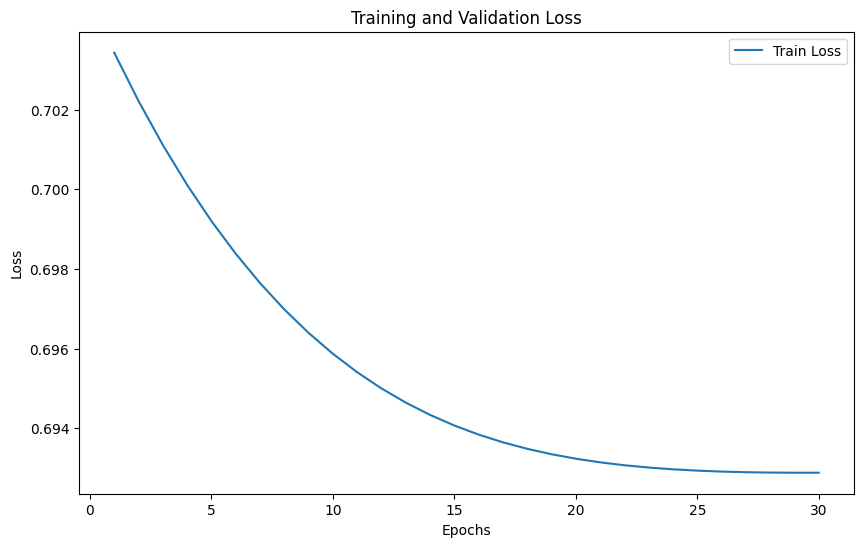

In [ ]:
# Visualize Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### Model Evaluation

In [ ]:
# Evaluate model on test data
h_prev_test = np.zeros((hidden_dim, 1))
c_prev_test = np.zeros((hidden_dim, 1))
test_loss = 0

predictions = []
actual_values = []

for i in range(len(X_test)):
    X_sequence = X_test.iloc[i].values.reshape(-1, X_test.shape[1])
    y_true = y_test[i].reshape(-1, 1)

    # Forward pass
    _, y_preds = lstm_forward(X_sequence, h_prev_test, c_prev_test, weights, biases)
    y_pred = y_preds[-1]

    # Accumulate loss
    test_loss += compute_loss(y_true, y_pred)

    # Store predictions and actual values
    predictions.append(y_pred.flatten()[0])
    actual_values.append(y_true.flatten()[0])

In [ ]:
# Compute average test loss
test_loss /= len(X_test)
print(f"Test Loss (Binary Cross-Entropy): {test_loss:.4f}")

Test Loss (Binary Cross-Entropy): 0.6930


In [ ]:
# Convert predictions to binary (0 or 1) using a threshold of 0.5
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, binary_predictions, target_names=["No Failure", "Failure"]))



Classification Report:
              precision    recall  f1-score   support

  No Failure       0.98      0.48      0.65      1939
     Failure       0.04      0.72      0.08        61

    accuracy                           0.49      2000
   macro avg       0.51      0.60      0.36      2000
weighted avg       0.95      0.49      0.63      2000



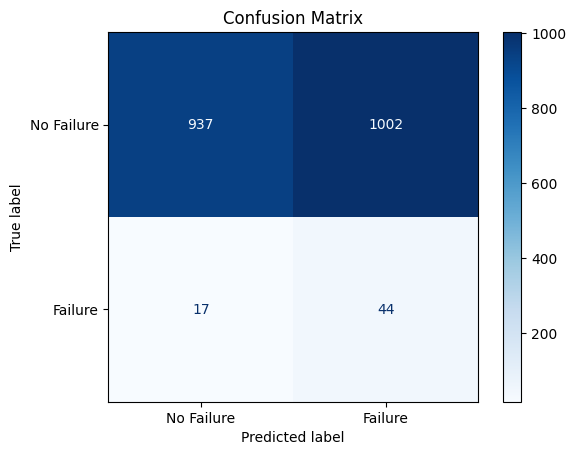

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Failure", "Failure"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

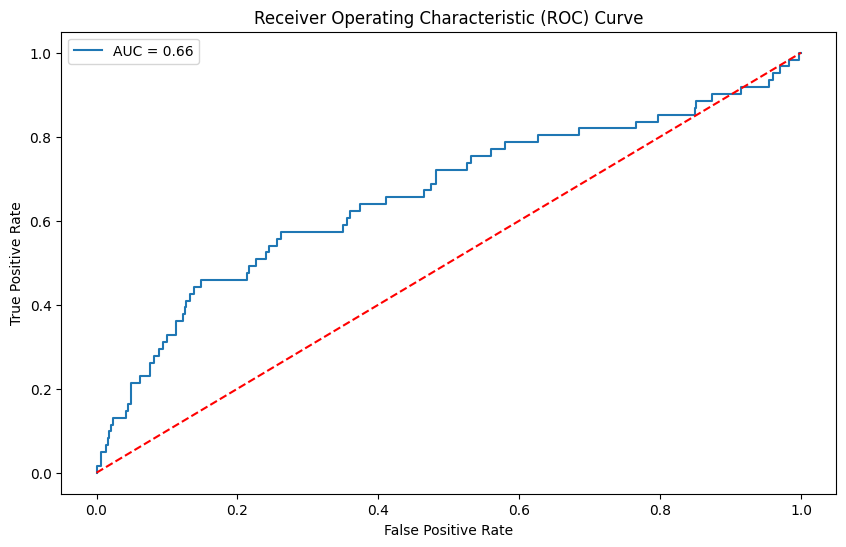

In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()